# Integration Tests for the Implicit Gradient Engines
$
\newcommand{\bvec}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\tr}{\text{tr}}
\newcommand{\te}{\text{te}}
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}
\renewcommand{\vec}{\boldsymbol}
\renewcommand{\(}{\left(}
\renewcommand{\)}{\right)}
\newcommand{\R}{\mathbb{R}}
\newcommand{\N}{\mathbb{N}}
\newcommand{\det}[1]{\left|#1\right|}
$

Unit tests are in `../../tests/implicit_grad_engine.py`. Integration tests are here because LaTeX is useful to derive theoretical answers.

## Imports & Setup

In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=2

import sys
sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%autoreload
from implicit_gradients.implicit_grad_engine import *
import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# plt.style.use('ggplot')
%matplotlib inline

## Integration Tests
### Functional Test Cases
#### 1D Linear Model

A simple setup. We'll have a 2D data set $\mathcal D = \{(-1, -1), (0, 0), (1, 1)\}$, and we'll try to learn the optimal slope $m$ to fit $\vec x$ to $\vec y$. We'll modulate this by a scaler hyperparameter $L$, which we'll multiply by $m$ in training. We'll initialize $m$ to $-1$ (so $L$ has nonzero contribution at first), and initialize $L$ to 0.5. The optimal value of $L$ should be 1, so that the multiplication by it does nothing and the system learns the right thing. We'll use a MSE loss. By sheer luck, with these values one-step of GD gives optimal train-set parameters. Note that at optimality, $m^*(L) = \frac{1}{L}$ as the true slope of the data is $1$ and the effective slope given our $L$ modulation is $mL$.

In particular, we'll have

$$
\begin{align}
  \alpha           &= 1 \\
  \vec x           &= \bvec{1, -1, 0}\\
  \vec y           &= \bvec{1, -1, 0} \\
  m^{(0)}          &= -1 \\
  L                &= 0.5 \\
  \ell_\tr         &= \sum_{i=1}^3 (y_i - Lm^{(0)}x_i)^2 \\
  m^{(1)}          &= m^{(0)} - \alpha \left.\pd{\ell_\tr}{m}\right|_{\vec m^{(0)}} \\
                   &= m^{(0)} - \alpha \sum_{i=1}^3 2 (y_i - Lm^{(0)} x_i) (-L x_i) \\
                   &= m^{(0)} - \alpha 2 \((1 - \frac12(-1)(1)) (-\frac12(1)) + (-1 - \frac12(-1)(-1))(-\frac12(-1)) + (0 - \frac12(-1)(0))(-\frac12(0))\)  \\
                   &= m^{(0)} - \alpha \((1 + \frac 12)(-1) + (-1 - \frac 12)\) \\
                   &= m^{(0)} - \alpha(-3) \\
                   &= 2 \\
                   &= m^* \\
  \ell_\te         &= \sum_{i=1}^3 (y_i - m^{(1)}x_i)^2 \\
  \pd{\ell_\te}{L} &= \sum_{i=1}^3 2(y_i - m^{(1)}x_i) \(- x_i \pd{m^{(1)}}{L}\) \\
                   &= \sum_{i=1}^3 2(y_i - 2x_i) \(-x_i \pd{}{L}\(- \alpha \sum_{j=1}^3 2 (y_j - Lm^{(0)} x_j) (-L x_j)\)\) \\
                   &= \sum_{i=1}^3 4\alpha x_i (y_i - 2x_i) \(\sum_{j=1}^3 \pd{}{L}\((y_j - Lm^{(0)} x_j) (-L x_j)\)\) \\
                   &= \sum_{i=1}^3 4\alpha x_i (y_i - 2x_i) \(\sum_{j=1}^3 (-L x_j)\pd{}{L}\((y_j - Lm^{(0)} x_j)\) + (y_j - Lm^{(0)} x_j)\pd{}{L}(-L x_j)\) \\
                   &= \sum_{i=1}^3 4\alpha x_i (y_i - 2x_i) \(\sum_{j=1}^3 (-L x_j)(-x_j m^{(0)}) + (y_j - Lm^{(0)} x_j)(-x_j)\) \\
                   &= \sum_{i=1}^3 4\alpha x_i (y_i - 2x_i) \(\sum_{j=1}^3 2L x_j^2 m^{(0)} - x_jy_j\) \\
                   &= 4\sum_{i=1}^3 x_i (y_i - 2x_i) \(-\sum_{j=1}^3 x_j(x_j + y_j)\) \\
                   &= -16\sum_{i=1}^3 x_i (y_i - 2x_i) \\
                   &= 32
\end{align}
$$

This is actually wrong. We can see this because clearly we want to _increase_ L here, not decrease it, and if we followed GD with a gradient of 32, we'd decrease it further. Upon reflection, it is clear this is wrong because by using an implicit method we're not really trying to differentiate through one-step of sgd here. Instead, we're _really_ differentiating through SGD to convergence, which could go for more steps and thus induce greater dependence on $L$. Not sure how to best represent this, but Mathematica agrees that the correct answer is -16, which is both (1) in the right direction (as the optimal $L$ should be $1$), and (2) agrees with the code output below! This is a good sign, but we need more tests.

In [3]:
learning_rate = 1
x = torch.tensor([-1, 0, 1])
y = torch.tensor([-1, 0, 1])
m = torch.tensor(-1.).requires_grad_(True)
L = torch.tensor(0.5).requires_grad_(True)

train_opt = torch.optim.SGD([m], lr = learning_rate)

train_opt.zero_grad()
train_loss = torch.sum((y - L*m*x)**2)
train_loss.backward()
train_opt.step()

train_loss = torch.sum((y - L*m*x)**2)

val_loss = torch.sum((y - m*x)**2)
val_grad = torch.autograd.grad(val_loss, [m])

E = NeumannInverseHessianApproximationEngine(1000, False)
out = E.implicit_grad(
    val_grad, train_loss, [m], [L], learning_rate, direct_val_meta_grad=None
)
print(m, out)

tensor(2., requires_grad=True) [tensor(-16.)]


We can consider differentiating through the full solution:
$m^* = \frac{1}{L}$, so $\pd{\ell_\te}{L} = 2\sum_{i=1}^3 (y_i - \frac{1}{L}x_i)\(\frac{x_i}{L^2}\)$, which, as $y_i = x_i$ here, is $2\frac{L-1}{L^3}\sum_{i=1}^3 x_i^2 = 4\frac{L-1}{L^3}$

For $L = \frac{1}{2}$ this becomes $4 \frac{-\frac{1}{2}}{\frac{1}{8}} = 4\cdot(-4) = -16$. This agrees with the finding above, and with that found by mathematica. However, it is independent of `learning_rate`, whereas the true approximation does not appear to be. It is unclear why, as of yet. Let's profile this a bit more, with this theoretical framing to back us and with iteration proceeding until convergence, not just for a set number of steps

In [69]:
def run_simple_model(
    L_lr = 0.001, L_init=0.5, m_init=-1.0, use_exact_grad=False,
    thresh=1e-9, num_hvp_iters=None, iter_cap = 100000, learning_rate=1.0,
    W = 7, num_outer_epochs=40,
):
    L = torch.tensor(L_init).requires_grad_(True)

    ms, Ls, train_losses, losses, grads, iters_needed = [], [], [], [], [], []
    true_grads, losses_in_training = [], []
    for outer_epoch in range(num_outer_epochs):
        x = torch.tensor([-1, 0, 1])
        y = torch.tensor([-1, 0, 1])
        m = torch.tensor(m_init).requires_grad_(True)
        train_opt = torch.optim.SGD([m], lr = learning_rate)
        train_loss = torch.sum((y - L*m*x)**2)
        f_loss = float(train_loss.detach().cpu().numpy())

        i = 0
        in_training_ls = []
        while (f_loss > thresh) and (i <= iter_cap):
            train_opt.zero_grad()
            train_loss = torch.sum((y - L*m*x)**2)
            f_loss = float(train_loss.detach().cpu().numpy())
            in_training_ls.append(f_loss)

            train_loss.backward()
            train_opt.step()

            train_loss = torch.sum((y - L*m*x)**2)
            i += 1
        losses_in_training.append(in_training_ls)

        if torch.isnan(m):
            print("NaN obtained on outer_epoch %d" % outer_epoch)
            break
        if torch.isinf(m):
            print("Inf obtained on outer_epoch %d" % outer_epoch)
            break

        iters_needed.append(i)
        train_losses.append(f_loss)

        val_loss = torch.sum((y - m*x)**2)
        val_grad = torch.autograd.grad(val_loss, [m])

        true_grad = (4 * (L - 1) / (L**3)).detach()
        true_grads.append(float(true_grad.cpu().numpy()))
        
        if use_exact_grad: out = [true_grad]
        else:
            if num_hvp_iters is None: num_hvp_iters = i
            E = NeumannInverseHessianApproximationEngine(num_hvp_iters, False)
            out = E.implicit_grad(
                val_grad, train_loss, [m], [L], learning_rate, direct_val_meta_grad=None
            )

        ms.append(float(m.detach().cpu().numpy()))
        Ls.append(float(L.detach().cpu().numpy()))
        losses.append(float(val_loss.detach().cpu().numpy()))
        grads.append(float(out[0].detach().cpu().numpy()))

        L = L - L_lr * out[0]
    
    fig, (
        (ax_loss, null),
        (ax_L, ax_m),
        (ax_grad, ax_grad_by_L)
    ) = plt.subplots(
        nrows=3, ncols=2, figsize=(3*W, 2*W)
    )
    
    ax_train_losses = fig.add_subplot(3, 2, 2, projection='3d')
        
    null.axis('off')
    ax_train_losses.set_title("Losses in training")
    ax_train_losses.set_xlabel("Outer Epoch #")
    ax_train_losses.set_ylabel("Inner Epoch #")
    ax_train_losses.set_zlabel("Loss")
    
    ax_loss.set_title("Losses")
    ax_loss.set_xlabel("Epoch #")
    ax_loss.set_ylabel("Validation Loss")
    ax_loss.set_xlim(0, len(Ls)+1)
    
    ax_L.set_title("$L$ iterates")
    ax_L.set_xlabel("Epoch #")
    ax_L.set_ylabel("$L$")
    ax_L.set_xlim(0, len(Ls)+1)

    ax_m.set_title("$m$ Values")
    ax_m.set_xlabel("Epoch #")
    ax_m.set_ylabel("Converged $m$ value")
    ax_m.set_xlim(0, len(Ls)+1)
    
    ax_grad.set_title("Gradients")
    ax_grad.set_xlabel("Epoch #")
    ax_grad.set_ylabel("$\\frac{\\partial \\ell_{te}}{\\partial L}$")
    ax_grad.set_xlim(0, len(Ls)+1)

    ax_grad_by_L.set_title("Gradients v. $L$")
    ax_grad_by_L.set_xlabel("$L$")
    ax_grad_by_L.set_ylabel("$\\frac{\\partial \\ell_{te}}{\\partial L}$")
    
    handles, labels = [], []
    val_loss_h, = ax_loss.plot(losses, label="Val Loss")
    tr_loss_ax = ax_loss.twinx()
    tr_loss_ax.set_ylabel("Train Loss")
    tr_loss_ax.set_yscale('log')
    tr_loss_h, = tr_loss_ax.plot(train_losses, label="Train Loss", color='k')
    handles.extend([val_loss_h, tr_loss_h])
    labels.extend(['Val Loss', 'Train Loss'])
    ax_loss.legend(handles, labels)
    handles, labels = [], []
    
    max_iterations = 0
    no_nans = []
    for tr in losses_in_training:
        no_nan = [l for l in tr if not np.isnan(l) and not np.isinf(l)]
        max_iterations = max(max_iterations, len(no_nan))
        no_nans.append(no_nan)
        
    padded_max_iterations = np.array([
        (tr + [np.NaN] * (max_iterations - len(tr))) for tr in no_nans
    ])
    num_outer_epochs = len(padded_max_iterations)
    Xs, Ys = np.meshgrid(np.arange(num_outer_epochs), np.arange(max_iterations))
    Zs = np.nan_to_num(padded_max_iterations.T, 1e-9)

    surf = ax_train_losses.plot_surface(
        Xs, Ys, Zs, cmap=cm.coolwarm
    )
    
    L_h, = ax_L.plot(Ls + [float(L.detach().cpu().numpy())], label="$L$")
    handles.append(L_h)
    labels.append("$L$")
    ax_L.legend(handles, labels)
    handles, labels = [], []
    
    true_Ms = [1/l for l in Ls]
    obs_m_h, = ax_m.plot(ms, label="Observed $m$", linestyle='dashed')
    true_m_h, = ax_m.plot(true_Ms, label="True (theory) $m$", linestyle='dotted')
    handles.extend([obs_m_h, true_m_h])
    labels.extend(["Observed $m$", "True (theory) $m$"])
    ax_m.legend(handles, labels)
    handles, labels = [], []
    
    obs_grad_h, = ax_grad.plot(grads)
    true_grad_h, = ax_grad.plot(true_grads)
    handles.extend([obs_grad_h, true_grad_h])
    labels.extend([
        "Observed $\\frac{\\partial \\ell_{te}}{\\partial L}$",
        "True (theory) $\\frac{\\partial \\ell_{te}}{\\partial L}$",
    ])
    ax_grad.legend(handles, labels)
    handles, labels = [], []
    
    order = np.argsort(Ls)
    obs_grad_L_h, = ax_grad_by_L.plot(np.array(Ls)[order], np.array(grads)[order])
    true_grad_L_h, = ax_grad_by_L.plot(np.array(Ls)[order], np.array(true_grads)[order])
    handles.extend([obs_grad_L_h, true_grad_L_h])
    labels.extend([
        "Observed $\\frac{\\partial \\ell_{te}}{\\partial L}$",
        "True (theory) $\\frac{\\partial \\ell_{te}}{\\partial L} = 4\\frac{L-1}{L^3}$",
    ])
    ax_grad_by_L.legend(handles, labels)
    handles, labels = [], []
    
    fig.tight_layout(pad=2.5)
    
    display(fig)
    fig.clear()

NaN obtained on outer_epoch 1


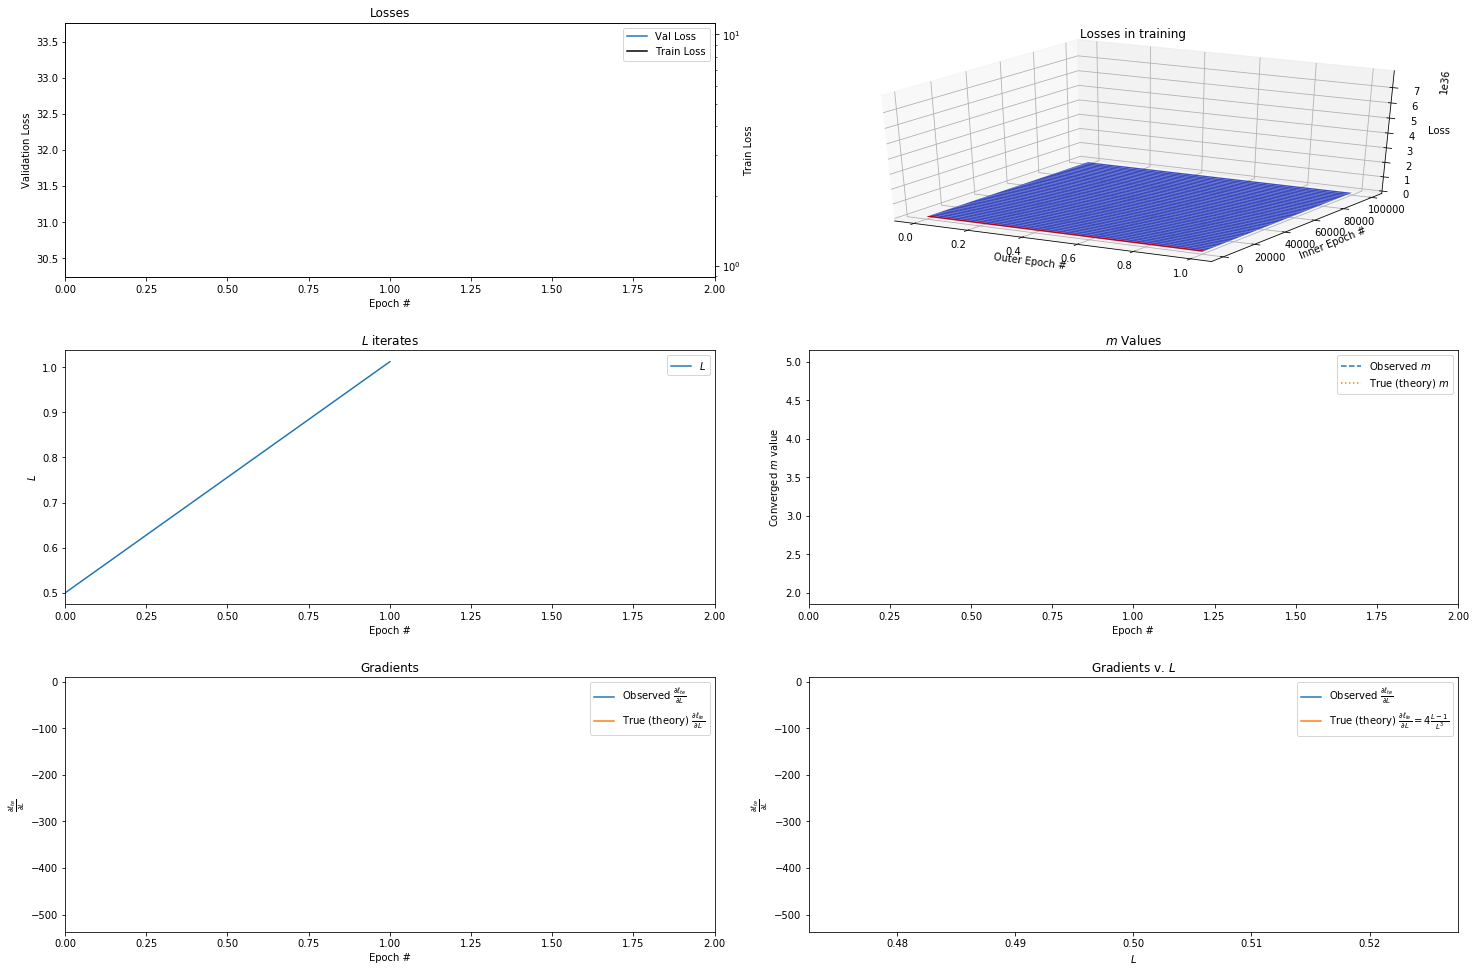

<Figure size 1512x1008 with 0 Axes>

In [79]:
run_simple_model(learning_rate=2)

NaN obtained on outer_epoch 18


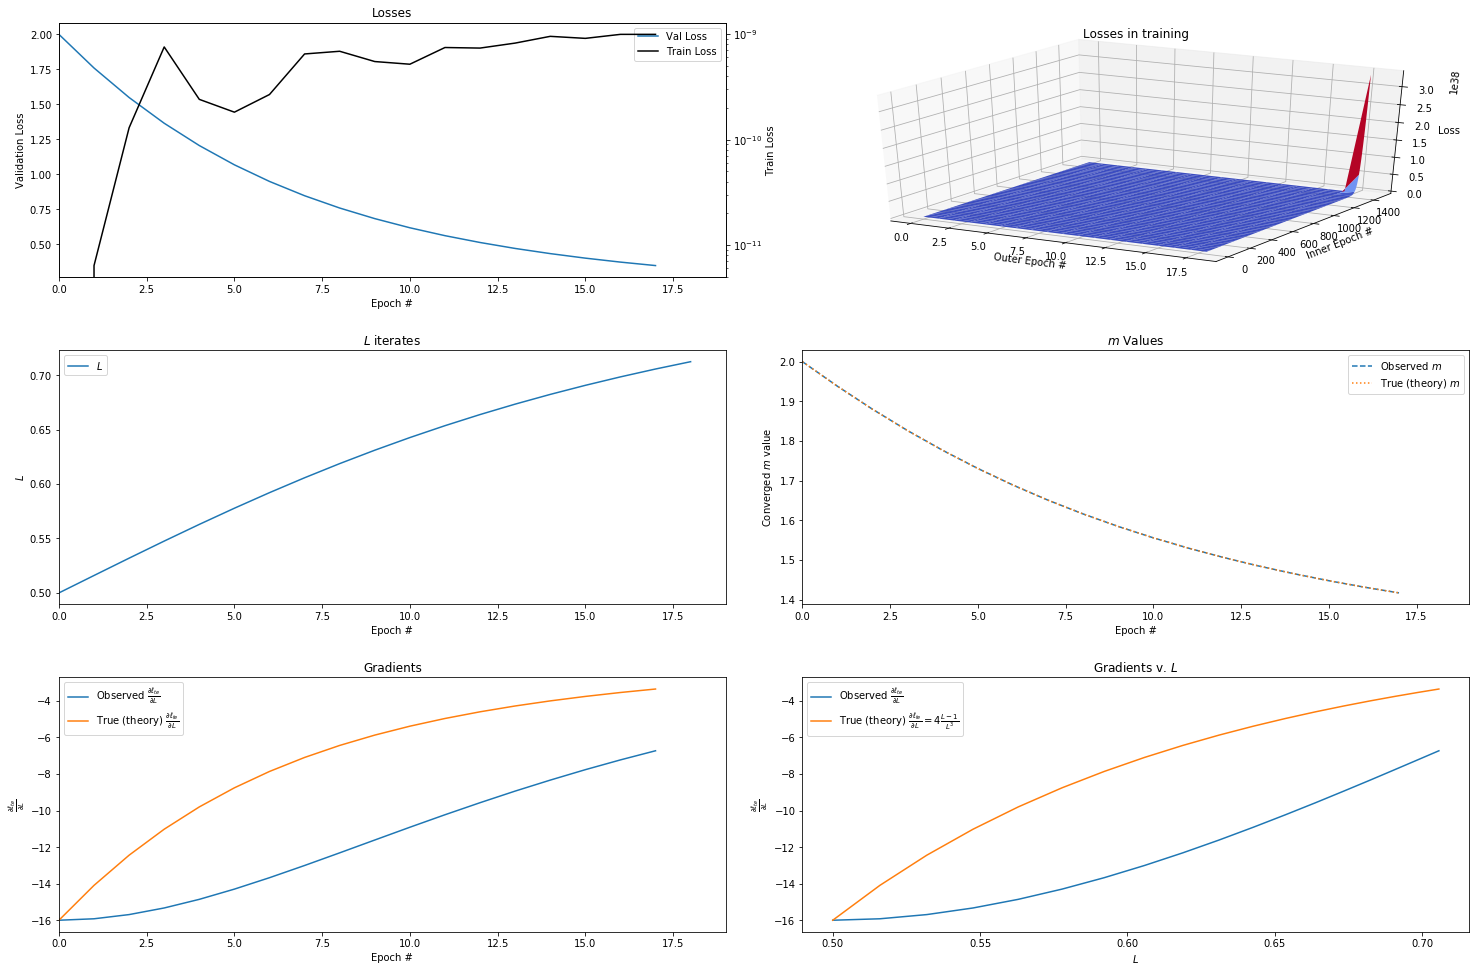

<Figure size 1512x1008 with 0 Axes>

In [70]:
run_simple_model(learning_rate=1)

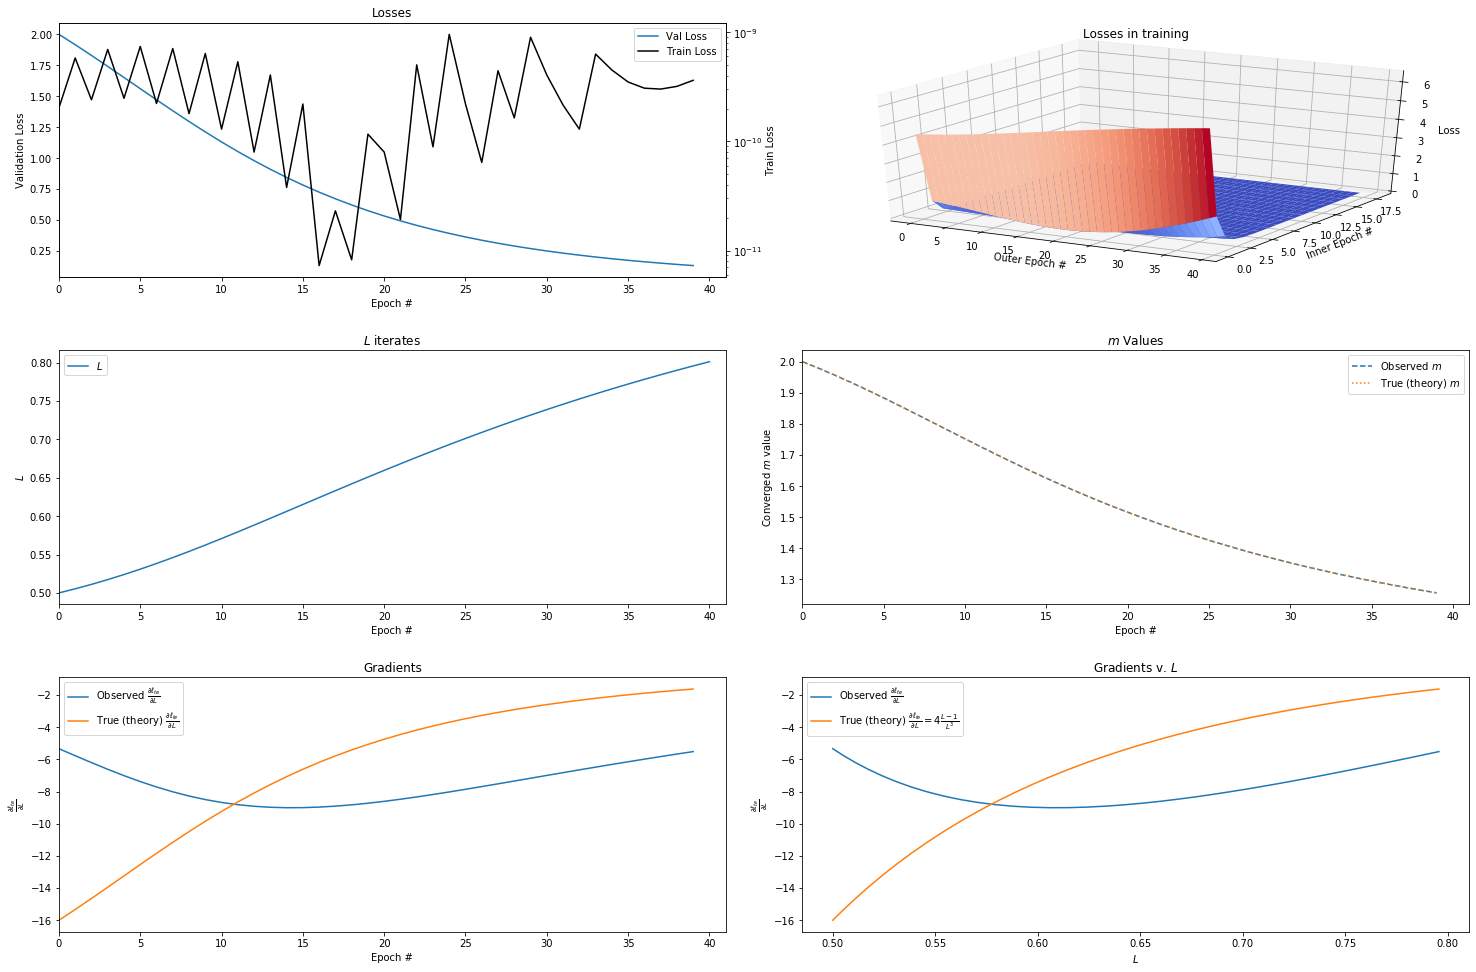

<Figure size 1512x1008 with 0 Axes>

In [71]:
run_simple_model(learning_rate=0.6)

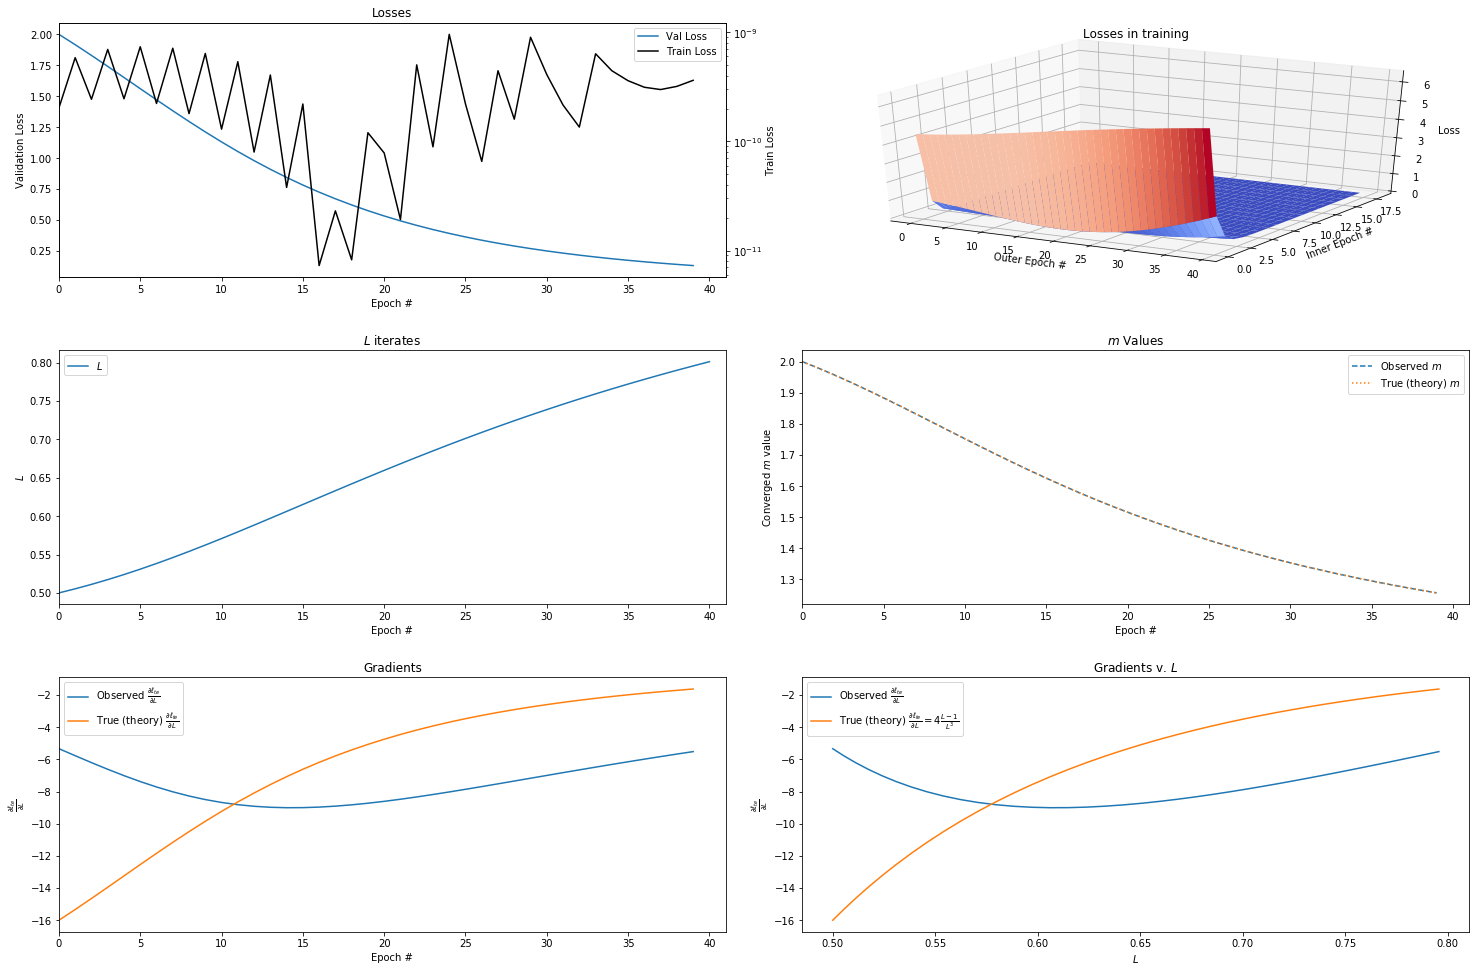

<Figure size 1512x1008 with 0 Axes>

In [72]:
run_simple_model(learning_rate=0.6, num_hvp_iters=10000)

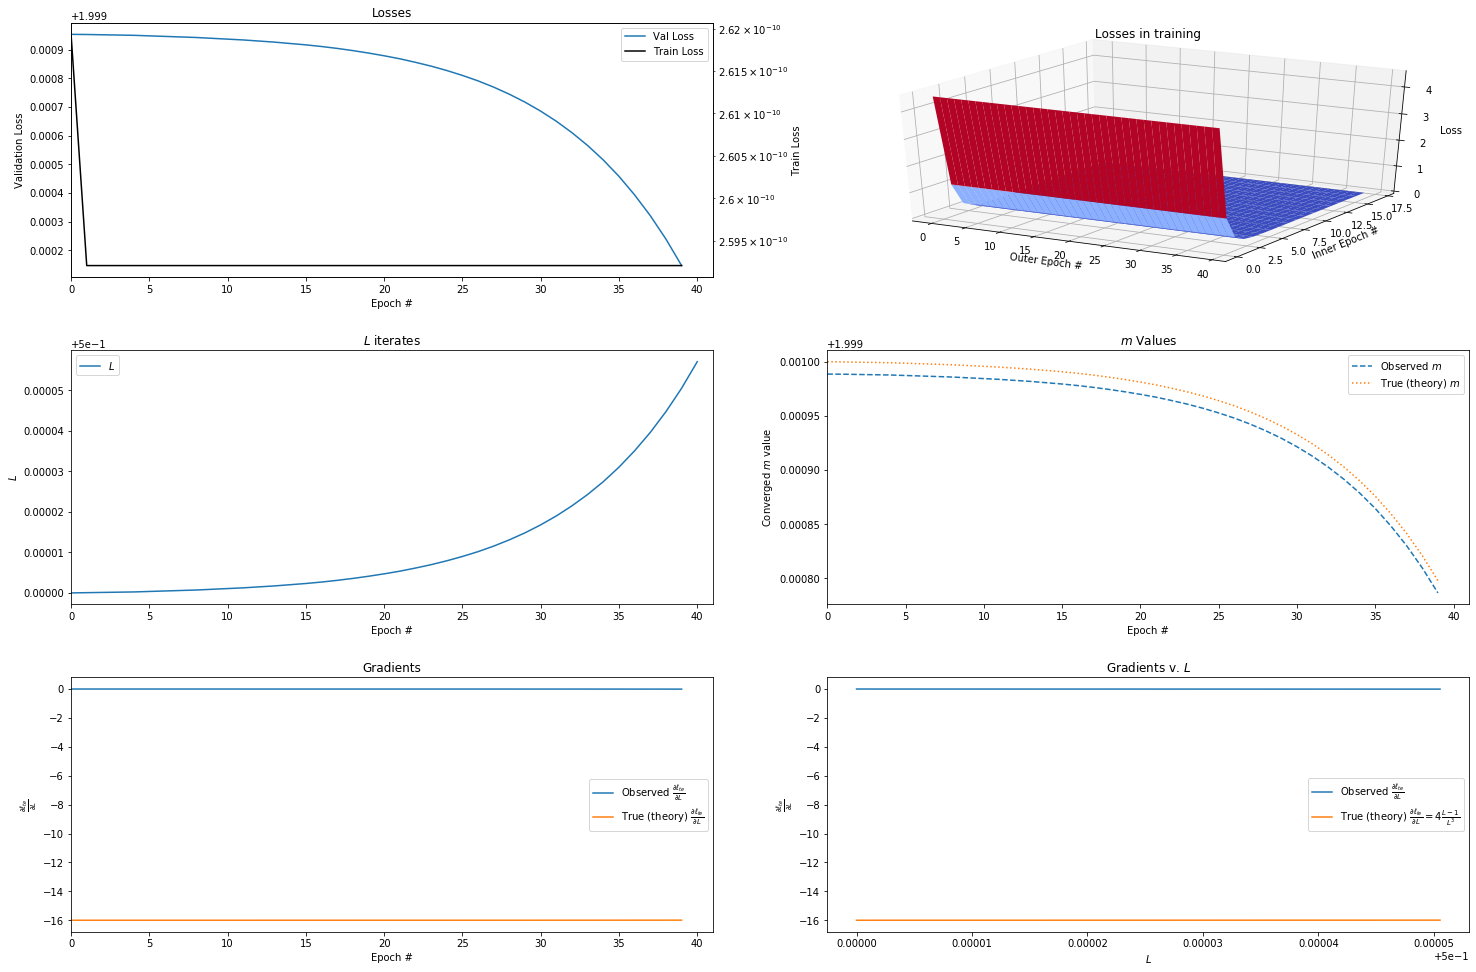

<Figure size 1512x1008 with 0 Axes>

In [73]:
run_simple_model(learning_rate=0.5)

NaN obtained on outer_epoch 10


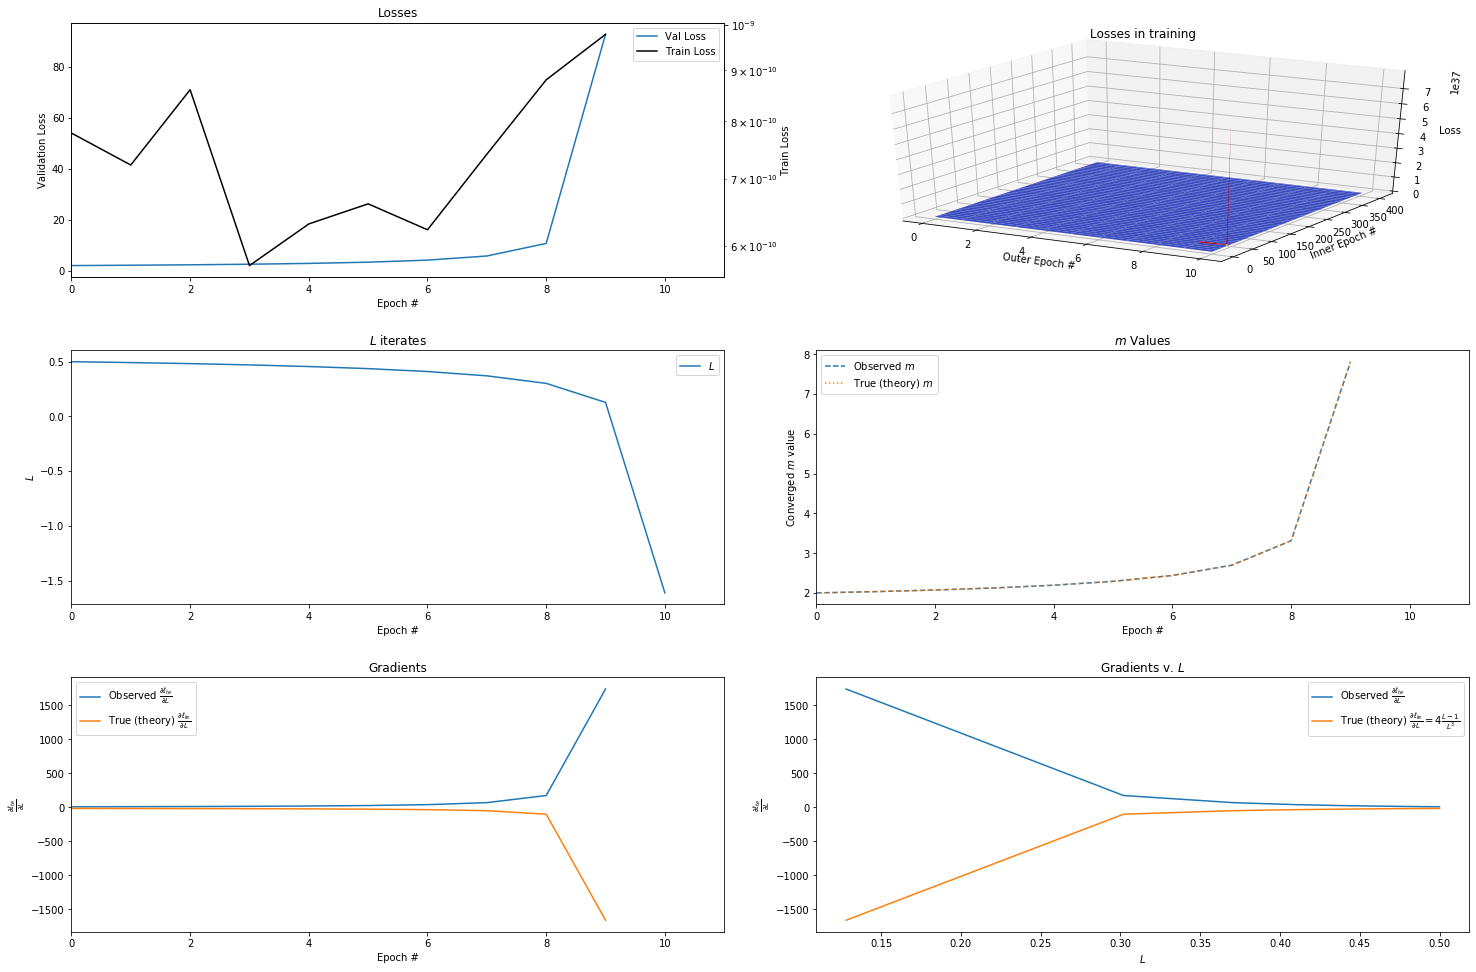

<Figure size 1512x1008 with 0 Axes>

In [74]:
run_simple_model(learning_rate=0.4)

NaN obtained on outer_epoch 3


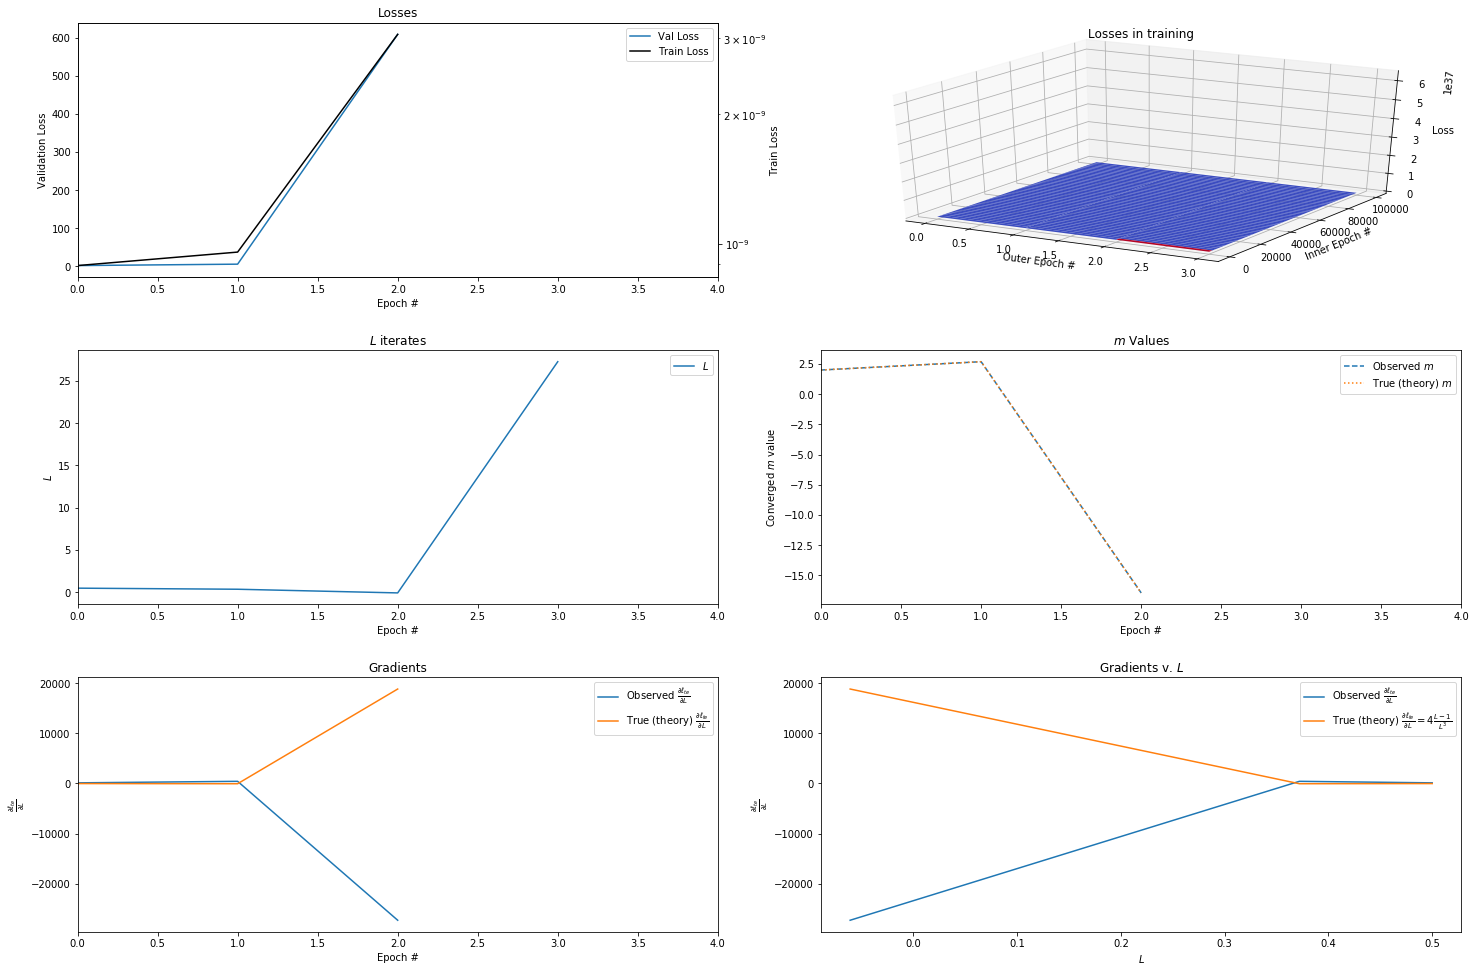

<Figure size 1512x1008 with 0 Axes>

In [75]:
run_simple_model(learning_rate=0.1)

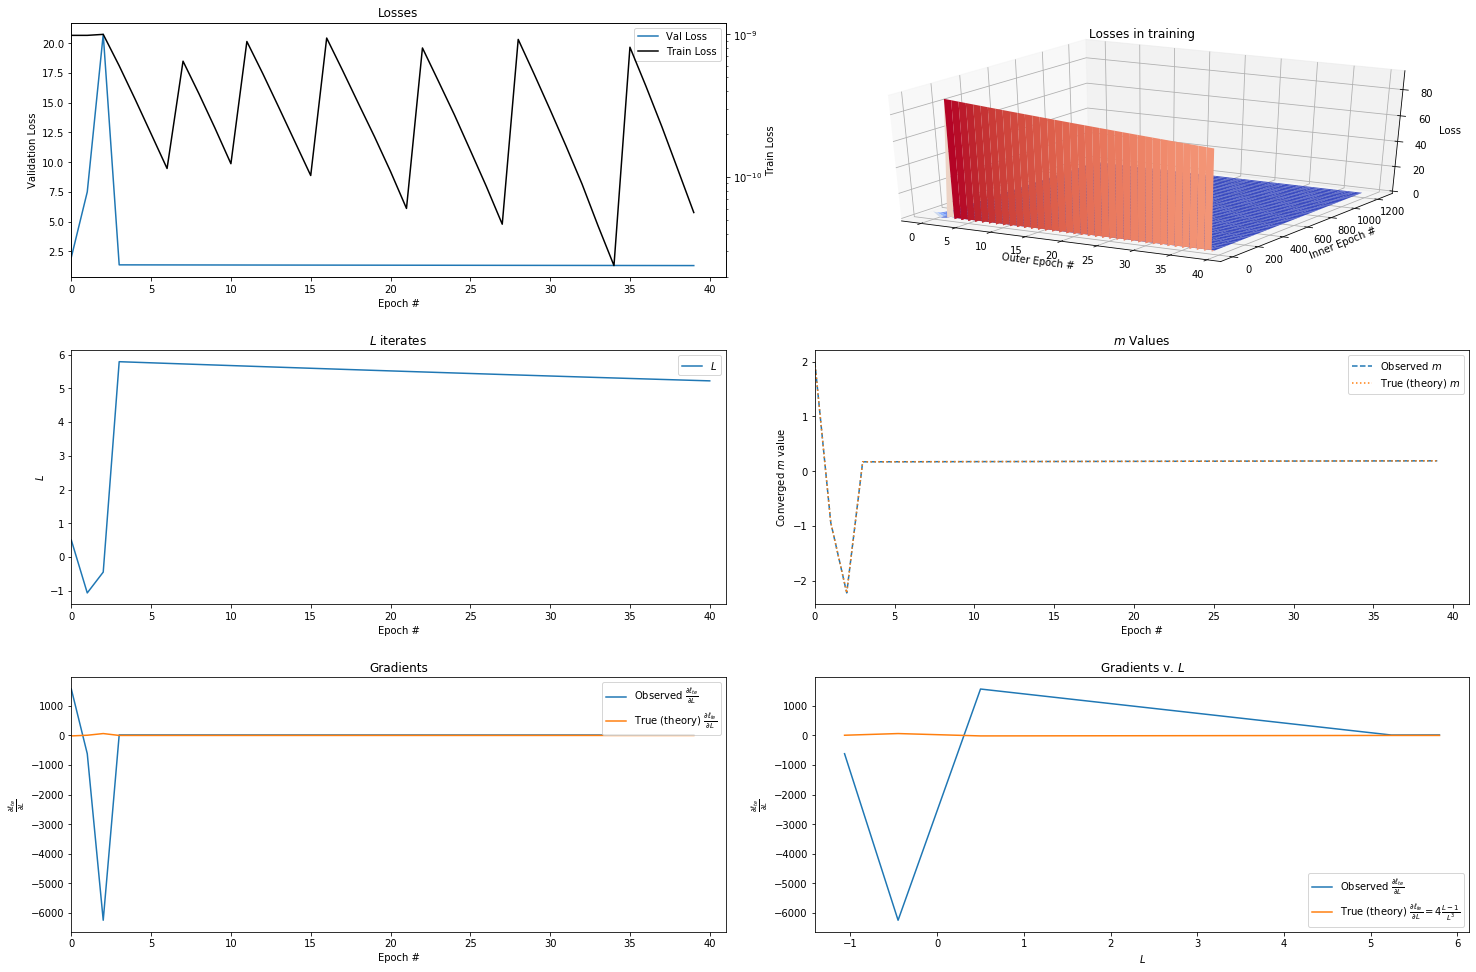

<Figure size 1512x1008 with 0 Axes>

In [76]:
run_simple_model(learning_rate=0.01)

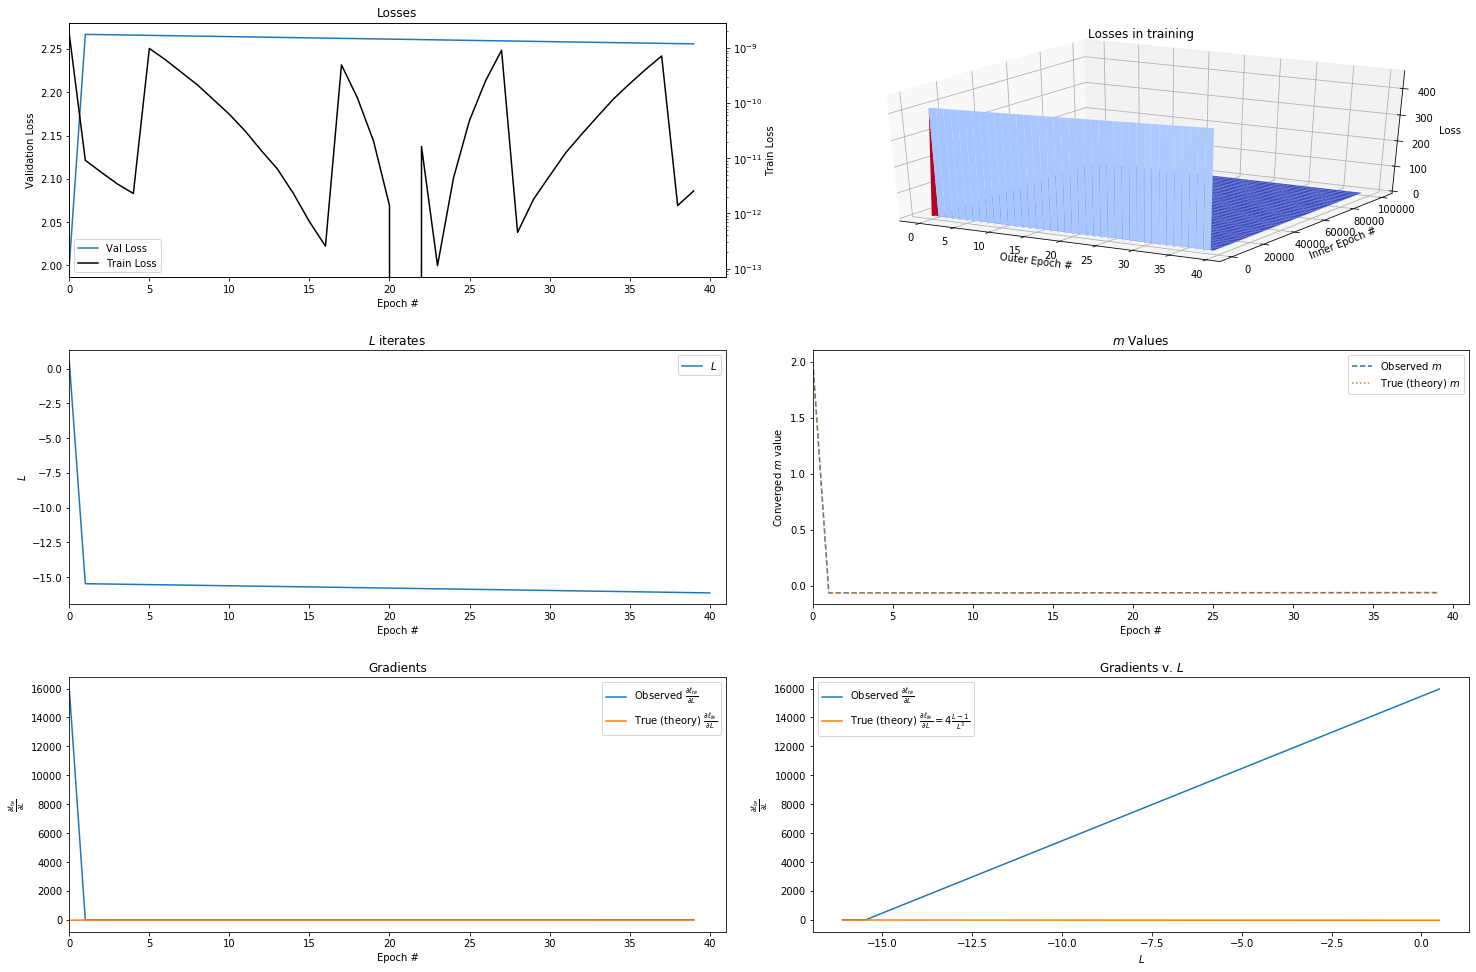

<Figure size 1512x1008 with 0 Axes>

In [77]:
run_simple_model(learning_rate=0.001)

NaN obtained on outer_epoch 1


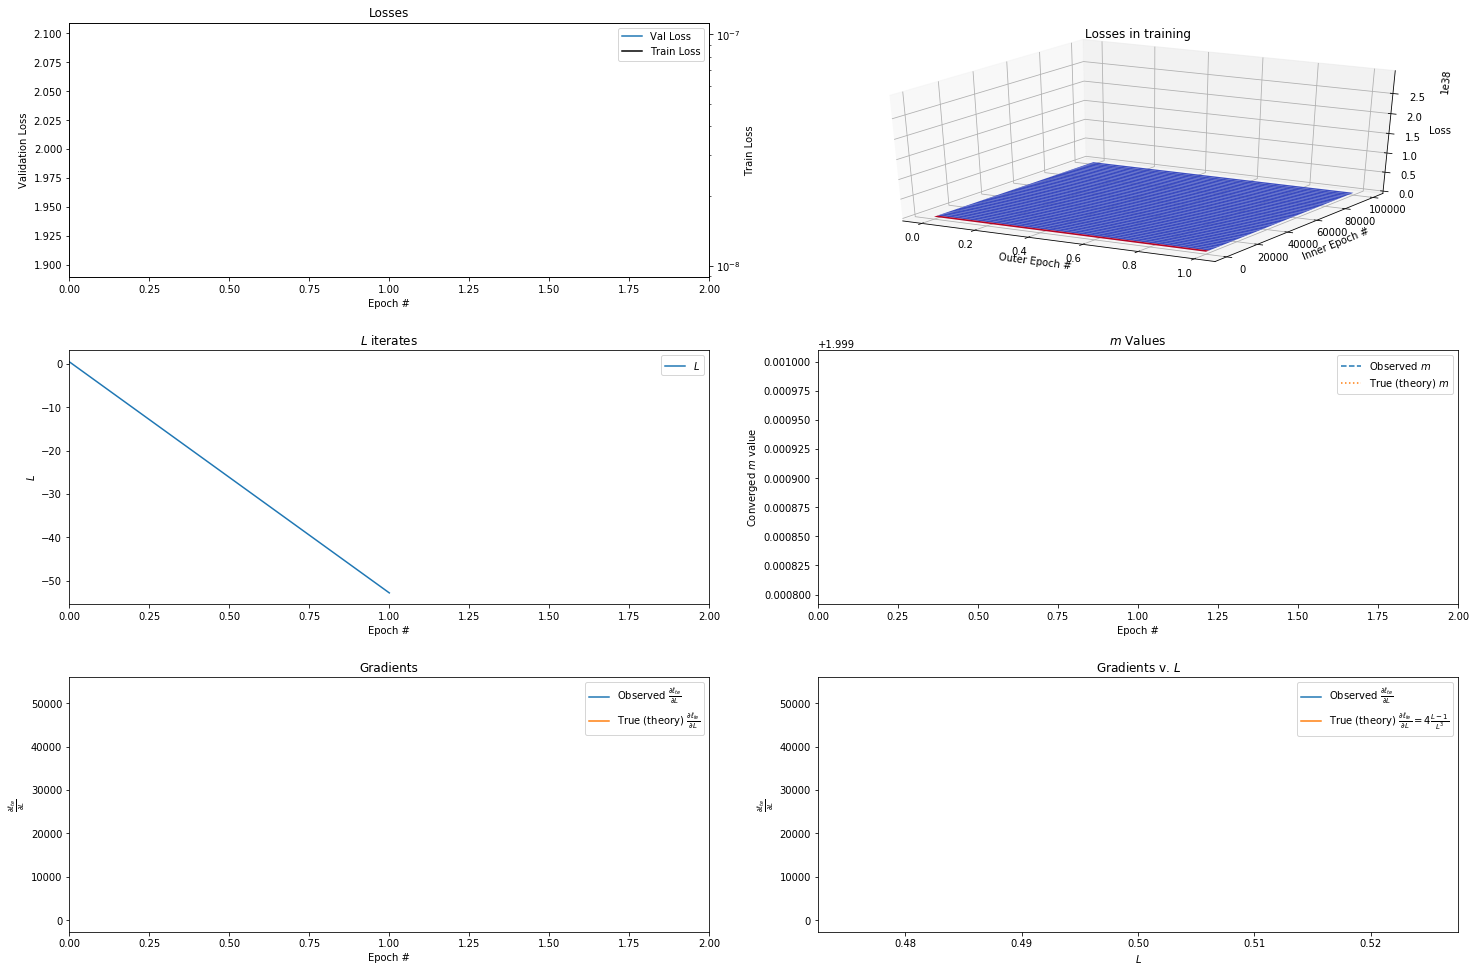

<Figure size 1512x1008 with 0 Axes>

In [78]:
run_simple_model(learning_rate=3e-4)

So this still doesn't seem right. Let's run through the assumptions necessary in the paper:
  1. $\mathcal L_V : \vec \Lambda \times \vec W \to \R$ is differentiable.
  2. $\mathcal L_T : \vec \Lambda \times \vec W \to \R$ is twice differentiable with an invertible Hessian at $\vec w^*(\vec \lambda)$.
  3. $\vec w^* : \vec \Lambda \to \vec W$ is differentiable.

Do we meet these assumptions?
  1. Yes, we meet this. $\mathcal L_V : (L, m) \mapsto \sum_{i=1}^3 (y_i - mx_i)^2 = \ell_\te$ is differentiable.
  2. $\mathcal L_T : (L, m) \mapsto \sum_{i=1}^3 (y_i - m L x_i)^2 = \ell_\tr$ is certainly differentiable, and $\pd {\ell_\tr}{m} = -2L\sum_{i=1}^3 x_i (y_i - m L x_i)$, $\pd {\ell_\tr}{L} = -2m\sum_{i=1}^3 x_i (y_i - m L x_i)$, which means 
    - $\frac{\partial^2 \ell_\tr}{\partial m \partial L} = -2 \sum_{i=1}^3 x_i (y_i - mLx_i) + 2Lm \sum_{i=1}^3 x_i^2 = -2 \sum_{i=1}^3 x_i y_i + 4 mL \sum_{i=1}^3 x_i^2$
    - $\frac{\partial^2 \ell_\tr}{\partial m^2} = 2 L^2\sum_{i=1}^3 x_i$
    - $\frac{\partial^2 \ell_\tr}{\partial L^2} = 2 m^2\sum_{i=1}^3 x_i$
    
  which are both definitely existent. Is the Hessian invertible? Well, the Hessian is
  $$
  \begin{align*}
  \vec H &= \bvec{
    \frac{\partial^2 \ell_\tr}{\partial m^2} & \frac{\partial^2 \ell_\tr}{\partial m \partial L} \\
    \frac{\partial^2 \ell_\tr}{\partial m \partial L} & \frac{\partial^2 \ell_\tr}{\partial L^2}
  }\\
    &= \bvec{
      4L^2 & -4 + 8mL \\
      -4 + 8mL & 4m^2
    }\\
    \det{\vec H} &= 16 L^2 m^2 + 8 - 16 mL \\
                 &= 8 + 16mL(mL - 1) \\
                 &= 8 + 16 (1  - 1) & \text{at optimality }m = \frac{1}{L} \\
                 &= 8 \\
                 &> 0
  \end{align*}
  $$
  so it is invertible.
  3. $m^*(L) = \frac{1}{L}$ which is differentiable.
  
Therefore, this _does_ seem to meet the assumptions of this method. Yet, still, it doesn't work.

### Old, broken test cases
#### Sign-flipping Sum
A simple setup. We'll have a vector $x$, which we'll try to minimize the sum of. We'll modulate this by a scaler hyperparameter $L$, which we'll multiply by $x$ in training. We'll do only one step in training, so we can compute exact meta-gradients.

In particular, we'll have

$$
\begin{align}
  \alpha           &= \frac{1}{2} \\
  \vec x^{(0)}     &= \bvec{1&1&1} \\
  L                &= -3 \\
  \ell_\tr         &= \sum_{i=1}^3 (x^{(0)}_i)^2 \cdot L \\
                   &= L \sum_{i=1}^3 (x^{(0)}_i)^2 \cdot L \\
  x^{(1)}_i        &= x^{(0)}_i - \alpha \left.\pd{\ell_\tr}{x_i}\right|_{\vec x^{(0)}} \\
                   &= 1 - \frac{1}{2} \cdot L \cdot 2 \cdot x^{(0)}_i \\
                   &= 1 - Lx^{(0)}_i \\
                   &= 4 \\
  \ell_\te         &= \sum_{i=1}^3 (x^{(1)}_i)^2 \\
  \pd{\ell_\te}{L} &= \sum_{i=1}^3 2 x^{1}_i \pd{x^{(1)}_i}{L} \\
                   &= \sum_{i=1}^3 8 \cdot (-x^{(0)}_i) \\
                   &= -24
\end{align}
$$

###### Following the code
What should the Neumann Inverse Hessian Approximation algorithm return?

```
val_grad   = grad(val_loss, [x_1])
           = [2 * x_1]
           = [[8, 8, 8]]
train_grad = grad(train_loss, [x])
           = [L * 2 * x_1]
           = [[-24, -24, -24]]
inv_HVP = approx_inverse_HVP(val_grad, train_grad, train_params, learning_rate)
  v = val_grad
  p = v
  [iter1]:
    diff = grad(train_grad, [x], grad_outputs=val_grad)
         = [2L,  0,  0] [8]
           [ 0, 2L,  0] [8]
           [ 0,  0, 2L] [8]
         = [-48...]
    v = v - learning_rate * diff
      = [8 - 0.5 * (-48)...] = [8 + 24...] = [32...]
    p = p - v
      = [8 - 32...] = -24
  [iter2]:
    diff = grad(train_grad, [x], grad_outputs=val_grad)
         = [2L,  0,  0] [32]
           [ 0, 2L,  0] [32]
           [ 0,  0, 2L] [32]
         = [-2*96...]
    v = v - learning_rate * diff
      = [8 - 0.5 * (-2*96)...] = [8 + 96...] = [104...]
    p = p - v
      = [-24 - 104...] = -[128...]
    
indirect_val_meta_grad 
  = -grad(train_grad, [L], grad_outputs = inv_HVP(iter = 1))
  = -[[2x_1,1, 2x_1,2, 2x_1,3]] * [-24]
                                  [-24]
                                  [-24]
  = Sum([48 * x_1...])
  = 3 * 192
  = 576
```

This is pretty clearly wrong. Why? Because this is in violation of the assumptions of the setup. Recall this system is based on the Implicit Function Theorem, which requires that we are operating in a region $(L', x')$ such that $\left.\pd{\ell_\tr}{\vec x}\right|_{L', x'} = 0$. That doesn't hold for this setup -- indeed, this system has no such point, because increasing $\vec x$ arbitrarily will increase the validation loss. So, we'll need a revised setting. We can also see that this setting is a bit dumb, b/c we have $\vec x = \bvec{1, 1, 1}$ which is a bit redundant (though it does check shapes, which is nice, I suppose).

In [38]:
x = torch.ones(3).float().requires_grad_(True)
learning_rate = 0.5
opt = torch.optim.SGD([x], lr=learning_rate)

L = torch.tensor(-3.0).requires_grad_(True)
train_loss = torch.sum((x**2)*L)
train_loss.backward()
opt.step()

train_loss = torch.sum((x**2)*L)

val_loss = torch.sum((x**2))
val_grad = torch.autograd.grad(val_loss, [x])
out = E.implicit_grad(
    val_grad, train_loss, [x], [L], learning_rate, direct_val_meta_grad=None
)

assert len(val_grad) == 1
assert (val_grad[0].detach().cpu().numpy() == np.array([8, 8, 8])).all()
assert len(out) == 1
out = out[0]
assert list(out.shape) == [], "Should be scalar"
f = float(out.detach().cpu().numpy())
assert f == -24, "Got wrong gradient! Want -24, got %.2f" % f

AssertionError: Got wrong gradient! Want -24, got -192.00